In [220]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from tableone import TableOne
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from keras.layers import Dense, LSTM, Bidirectional, Dropout
from keras.models import Sequential
from keras.layers import SimpleRNN
import tensorflow as tf


Functions that modify the Datasets

In [331]:
def impute_missing(data_sensors, column):
    before_imputation = data_sensors.copy()

    for index, row in data_sensors.iterrows():
        if pd.isna(row[column]):
            #prev row
            prev = data_sensors.loc[:index].loc[~data_sensors[column].isna()].tail(1)
            #next row
            next = data_sensors.loc[index:].loc[~data_sensors[column].isna()].head(1)

            if not (prev.empty or next.empty):
                mean = round((prev[column].values[0] + next[column].values[0]) / 2, 2)
                data_sensors.at[index, column] = mean

    
    changes = pd.DataFrame(columns=['Index', 'before', 'after'])
    for index, row in before_imputation.iterrows():
        before = row[column]
        after = data_sensors.at[index, column]
        if pd.notna(before) and pd.notna(after) and before != after:
            changes = changes.append({'Index': index, 'before': before, 'after': after}, ignore_index=True)

    return data_sensors, changes

def rename_sensor(data_sensors):

    sensor_ids = ['am3019-testqc2090', 'am307-9074', 'eui-24e124128c147204',
                  'eui-24e124128c147444', 'eui-24e124128c147446',
                  'eui-24e124128c147470', 'eui-24e124128c147499',
                  'eui-24e124128c147500', 'eui-24e124710c408089',
                  'eui-24e124725c461468', 'q4-1003-7456']
    #We will not use Biblio_Filo and AudioLab Data
    sensors_names = ['testqc2090', 'Computer_Room', 'Digital_Lab',
                  'Biblio_Filo', '24e124128c147446',
                  '24e124128c147470', 'AudioLab',
                  'OpenLab_Main_Room', 'OpenLab_Laser_Room',
                  '24e124725c461468', 'Classroom']
    
    mapp = dict(zip(sensor_ids, sensors_names))
    data_sensors['location'] = data_sensors['location'].map(mapp).fillna(data_sensors['location'])
    
    data_sensors = data_sensors[(data_sensors['location'] != 'Biblio_Filo') & (data_sensors['location'] != 'AudioLab')]
    
    return data_sensors


def combine_dataframes(sensor_name,data_meteo):
    data_meteo['DateTime'] = pd.to_datetime(data_meteo['Date'] + ' ' + data_meteo['Hour'])
    
    sensor_name['DateTime'] = pd.to_datetime(sensor_name['Date'] + ' ' + sensor_name['Hour'])

    #round the hours to the nearest multiple of 30 minutes
    sensor_name['DateTime'] = sensor_name['DateTime'].dt.round('30min')

    #combine Dataframes by datetime column
    combined = pd.merge(sensor_name, data_meteo, on='DateTime', how='inner')

    combined = combined.drop(columns=["DateTime","Date_y", "Hour_y", "location"])
    combined.rename(columns={'Date_x': 'Date'}, inplace=True)
    combined.rename(columns={'Hour_x': 'Hour'}, inplace=True)
    combined.rename(columns={'TM': 'TM_outdoor'}, inplace=True)
    combined.rename(columns={'HRM%': 'HRM%_outdoor'}, inplace=True)
    combined.rename(columns={'PPT': 'PPT_outdoor'}, inplace=True)
    combined.rename(columns={'RS': 'RS_outdoor'}, inplace=True)
    combined[['Hour', 'Minutes']] = combined['Hour'].str.split(':', expand=True)
    #combined['Hour'] = combined['Hour'].astype(int)
    #combined['Minutes'] = combined['Minutes'].astype(int)
    combined[['Day', 'Month', 'Year']] = combined['Date'].str.split('-', expand=True)
    #combined['Day'] = combined['Day'].astype(int)
    #combined['Month'] = combined['Month'].astype(int)
    #combined['Year'] = combined['Year'].astype(int)
    

    combined = combined[['Day', 'Month', 'Year', 'Hour', 'Minutes', 'co2', 'humidity', 'o3', 'pressure', 'temperature', 'tvoc', 'TM_outdoor', 'HRM%_outdoor', 'PPT_outdoor', 'RS_outdoor']]

    return combined



Functions to plot

In [222]:
def display_plot(data,x, y, fig_title):
    plt.figure(figsize = (20,7))
    plt.title(fig_title, loc='center', fontsize=20)
    sb.barplot(x = x, y = y, palette = 'cool') 
    plt.tight_layout();


def display_outliers(sensor_com):
    num_feats = [col for col in sensor_com.columns if sensor_com[col].dtype != 'object']

    fig, axes = plt.subplots(nrows=len(num_feats)//2, ncols=2, figsize=(16, 8 * (len(num_feats)//2)))
    axes = axes.flatten()

    #iterate over numerical features
    for i, col in enumerate(num_feats):
        #boxplot for each feature
        sb.boxplot(x=sensor_com[col], color='red', ax=axes[i])
        axes[i].set_title(f'Boxplot of {col}')
        axes[i].set_xlabel(col)

    plt.tight_layout()
    plt.show()

We have loaded the dataframes and modified the formats so that they are similar

In [333]:
data_meteo = pd.read_excel("C:/Users/migue/UAB_EnergyStudy/DataSets_/Meteo - Sensors Data/datos_meteo.xlsx")
data_sensors = pd.read_csv("C:/Users/migue/OneDrive/Escritorio/UAB INTELIGENCIA ARTIFICIAL/Segon Any/2B/nuevo_historic_sensors_data.csv")

data_meteo['Hora'] = data_meteo['Hora'].str.split(' - ').str[0]
data_meteo = data_meteo.rename(columns={'Fecha': 'Date'})
data_meteo = data_meteo.rename(columns={'Hora': 'Hour'})


data_sensors['Date'] = pd.to_datetime(data_sensors['Date'], format='%Y-%m-%d').dt.strftime('%d-%m-%Y')
data_sensors['Hour'] = pd.to_datetime(data_sensors['Hour'], format= '%H:%M:%S').dt.strftime('%H:%M')
data_sensors = data_sensors.drop(columns=['_measurement'])

In [224]:
data_sensors.shape

(1745335, 5)

We have created the columns based on the _field data to have the dataset more compressed, ordered and with more columns

In [7]:
data_sensors = data_sensors.pivot_table(index=['location', 'Date', 'Hour'], columns='_field', values='_value')
data_sensors = data_sensors.reset_index()
data_sensors['Date'] = pd.to_datetime(data_sensors['Date'], format='%d-%m-%Y')
data_sensors = data_sensors.sort_values(by=['location', 'Date', 'Hour'])
data_sensors['Date'] = pd.to_datetime(data_sensors['Date'], format='%Y-%m-%d').dt.strftime('%d-%m-%Y')

data_sensors = data_sensors.drop(columns=["activity","battery","infrared_and_visible", "pm10", "pm2_5", "illumination", "infrared", "light_level"])

In [8]:
data_sensors = rename_sensor(data_sensors)

In [9]:
data_sensors.shape

(193215, 9)

Missing Values

In [10]:
print(data_sensors[data_sensors.columns[data_sensors.isnull().sum()>0]].isnull().sum())
print(data_meteo[data_meteo.columns[data_meteo.isnull().sum()>0]].isnull().sum())

_field
co2               616
humidity          798
o3             129341
pressure        32485
temperature       801
tvoc            32307
dtype: int64
Series([], dtype: float64)


In [11]:
#tarda como 25 min
"""data_sensors, _ = impute_missing(data_sensors, "temperature")
data_sensors, _ = impute_missing(data_sensors, "humidity")
data_sensors, _ = impute_missing(data_sensors, "co2") 
data_sensors, _ = impute_missing(data_sensors, "pressure")
data_sensors, _ = impute_missing(data_sensors, "tvoc")"""

In [12]:
#data_sensors.fillna(0, inplace=True)
print(data_sensors[data_sensors.columns[data_sensors.isnull().sum()>0]].isnull().sum())

_field
o3    129341
dtype: int64


Duplicates

In [13]:
data_sensors.duplicated().sum()

0

In [14]:
data_sensors.describe()

_field,co2,humidity,o3,pressure,temperature,tvoc
count,193215.000000,193215.000000,63874.000000,193215.000000,193215.000000,193215.000000
mean,565.605978,46.974533,0.135181,998.801031,22.834601,142.759276
std,254.628069,11.026851,0.072241,9.485028,3.990670,175.868772
min,355.000000,20.500000,0.020000,960.500000,10.800000,0.000000
25%,445.000000,38.500000,0.060000,993.500000,20.200000,88.000000
50%,476.000000,46.500000,0.090000,1001.100000,22.700000,100.000000
75%,562.000000,56.000000,0.210000,1003.900000,25.300000,153.000000
max,3743.000000,77.000000,0.260000,1025.400000,36.500000,9738.000000


Minutes Round

In [217]:
data_sensors['Hour'] = pd.to_datetime(data_sensors['Hour'], format='%H:%M')
data_sensors['Hour'] = data_sensors['Hour'].apply(lambda x: datetime.strptime(x.strftime('%H:%M'), '%H:%M').replace(minute=(x.minute // 10) * 10))
data_sensors['Hour'] = pd.to_datetime(data_sensors['Hour'], format= '%H:%M:%S').dt.strftime('%H:%M')

'# Convertir las columnas "Hour" y "Minutes" a enteros\ndata_sensors[\'Hour\'] = data_sensors[\'Hour\'].astype(int)\ndata_sensors[\'Minutes\'] = data_sensors[\'Minutes\'].astype(int)'

In [65]:
#data_sensors.to_csv("data_sensors_v1.csv",index=False)  

# Recommender System

In [334]:
data_meteo

,Date,Hour,TM,HRM%,PPT,RS
0,25-07-2023,00:00,24.7,73,0.0,0
1,25-07-2023,00:30,24.4,74,0.0,0
2,25-07-2023,01:00,24.1,75,0.0,0
3,25-07-2023,01:30,23.9,75,0.0,0
4,25-07-2023,02:00,23.9,74,0.0,0
...,...,...,...,...,...,...
11995,30-03-2024,21:30,11.9,89,0.0,0
11996,30-03-2024,22:00,12.0,87,0.0,0
11997,30-03-2024,22:30,12.2,88,0.5,0
11998,30-03-2024,23:00,12.7,86,0.0,0


In [335]:
data_sensors = pd.read_csv("data_sensors_v1.csv")
data_sensors

,location,Date,Hour,co2,humidity,o3,pressure,temperature,tvoc
0,testqc2090,25-07-2023,13:50,472.0,36.0,0.05,996.9,27.8,100.0
1,testqc2090,25-07-2023,14:00,466.0,36.0,0.05,996.9,27.9,100.0
2,testqc2090,25-07-2023,14:10,466.0,36.0,0.05,996.9,27.9,100.0
3,testqc2090,25-07-2023,14:20,455.0,36.0,0.05,996.8,27.9,100.0
4,testqc2090,25-07-2023,14:30,463.0,36.0,0.05,996.7,28.0,100.0
...,...,...,...,...,...,...,...,...,...
193210,Classroom,30-03-2024,11:40,438.0,39.0,NaN,976.1,22.0,173.0
193211,Classroom,30-03-2024,11:50,427.0,38.5,NaN,976.2,22.3,180.0
193212,Classroom,30-03-2024,12:00,433.0,38.0,NaN,976.2,22.5,183.0
193213,Classroom,30-03-2024,12:10,426.0,38.0,NaN,976.2,22.7,184.0


In [336]:
data_sensors['location'].unique()

array(['testqc2090', 'Computer_Room', 'Digital_Lab', '24e124128c147446',
       '24e124128c147470', 'OpenLab_Main_Room', 'OpenLab_Laser_Room',
       '24e124725c461468', 'Classroom'], dtype=object)

In [337]:
testqc2090 = data_sensors[data_sensors['location'] == 'testqc2090']
Computer_Room = data_sensors[data_sensors['location'] == 'Computer_Room']
Digital_Lab = data_sensors[data_sensors['location'] == 'Digital_Lab']
c147446 = data_sensors[data_sensors['location'] == '24e124128c147446']
c147470 = data_sensors[data_sensors['location'] == '24e124128c147470']
OpenLab_Main_Room = data_sensors[data_sensors['location'] == 'OpenLab_Main_Room']
OpenLab_Laser_Room = data_sensors[data_sensors['location'] == 'OpenLab_Laser_Room']
c461468 = data_sensors[data_sensors['location'] == '24e124725c461468']
Classroom = data_sensors[data_sensors['location'] == 'Classroom']


We combine the two datasets to have only one (for date and time and for each sensor)

In [338]:
testqc2090_com = combine_dataframes(testqc2090,data_meteo)
Computer_Room_com = combine_dataframes(Computer_Room,data_meteo)
Digital_Lab_com = combine_dataframes(Digital_Lab,data_meteo)
c147446_com = combine_dataframes(c147446,data_meteo)
c147470_com = combine_dataframes(c147470,data_meteo)
OpenLab_Main_Room_com = combine_dataframes(OpenLab_Main_Room,data_meteo)
OpenLab_Laser_Room_com = combine_dataframes(OpenLab_Laser_Room,data_meteo)
c461468_com = combine_dataframes(c461468,data_meteo)
Classroom_com = combine_dataframes(Classroom,data_meteo)


C:\Users\migue\AppData\Local\Temp\ipykernel_2008\2630061426.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sensor_name['DateTime'] = pd.to_datetime(sensor_name['Date'] + ' ' + sensor_name['Hour'])
C:\Users\migue\AppData\Local\Temp\ipykernel_2008\2630061426.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sensor_name['DateTime'] = sensor_name['DateTime'].dt.round('30min')
C:\Users\migue\AppData\Local\Temp\ipykernel_2008\2630061426.py:50: SettingWithCopyWarning: 
A value is trying to be set on a cop

In [339]:
Computer_Room_com

,Day,Month,Year,Hour,Minutes,co2,humidity,o3,pressure,temperature,tvoc,TM_outdoor,HRM%_outdoor,PPT_outdoor,RS_outdoor
0,25,07,2023,13,50,431.0,37.0,NaN,997.6,27.4,100.0,31.0,25,0.0,808
1,25,07,2023,14,00,426.0,37.0,NaN,997.5,27.5,100.0,31.0,25,0.0,808
2,25,07,2023,14,10,438.0,37.0,NaN,997.6,27.5,100.0,31.0,25,0.0,808
3,25,07,2023,14,20,425.0,37.0,NaN,997.6,27.5,100.0,31.2,25,0.0,746
4,25,07,2023,14,30,442.0,36.5,NaN,997.5,27.6,100.0,31.2,25,0.0,746
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31484,30,03,2024,11,40,405.0,38.0,NaN,985.0,22.2,100.0,15.4,44,0.0,340
31485,30,03,2024,11,50,399.0,37.5,NaN,985.1,22.4,100.0,15.0,47,0.0,340
31486,30,03,2024,12,00,403.0,37.0,NaN,985.1,22.6,100.0,15.0,47,0.0,340
31487,30,03,2024,12,10,398.0,36.5,NaN,985.2,22.8,100.0,15.0,47,0.0,340


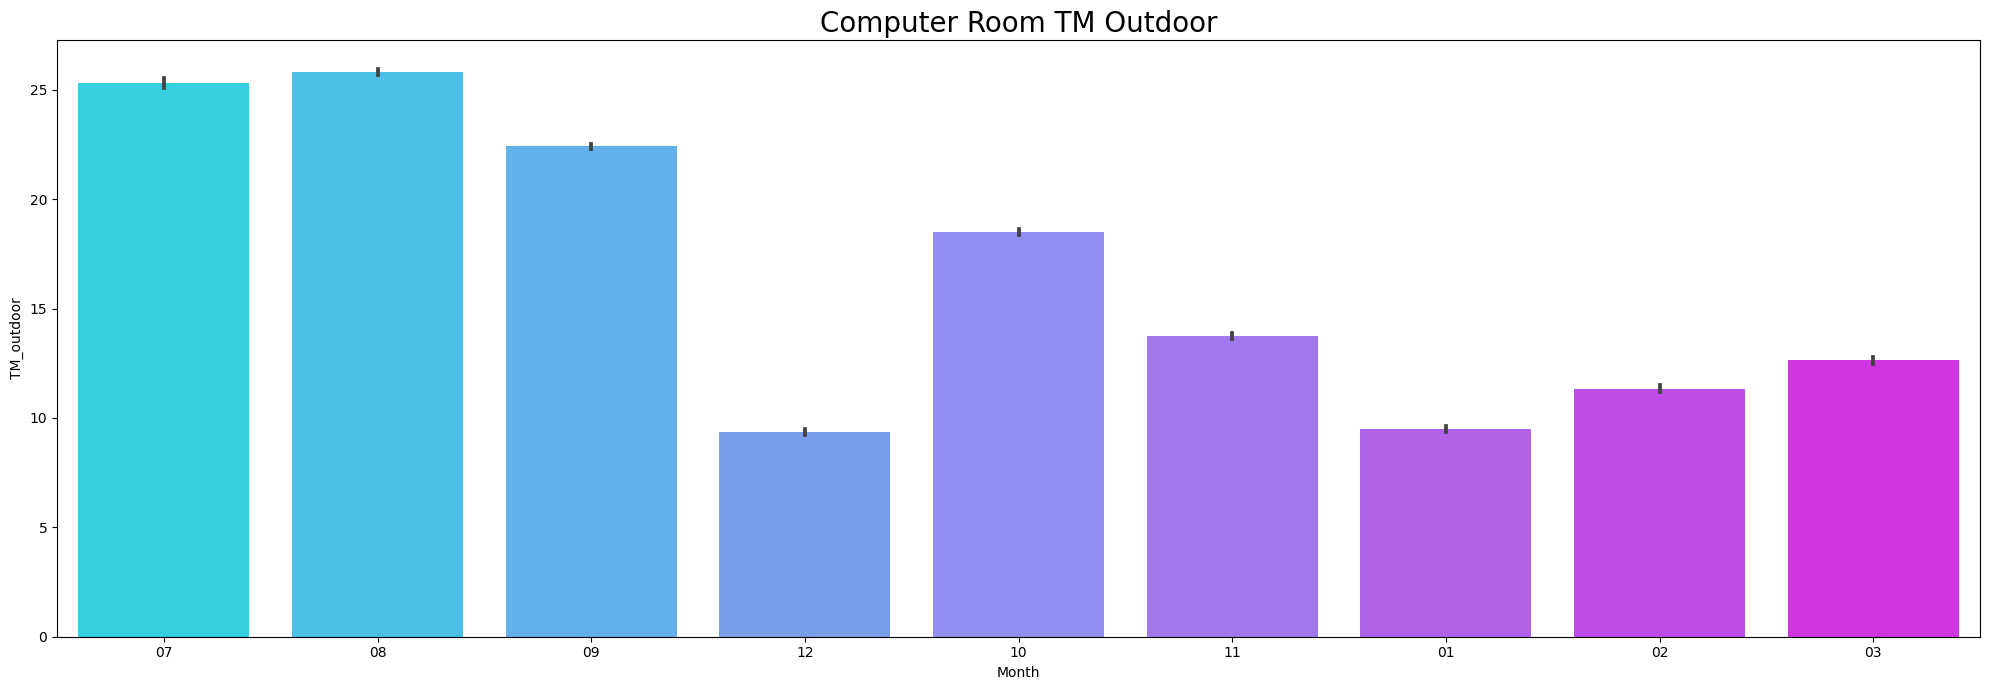

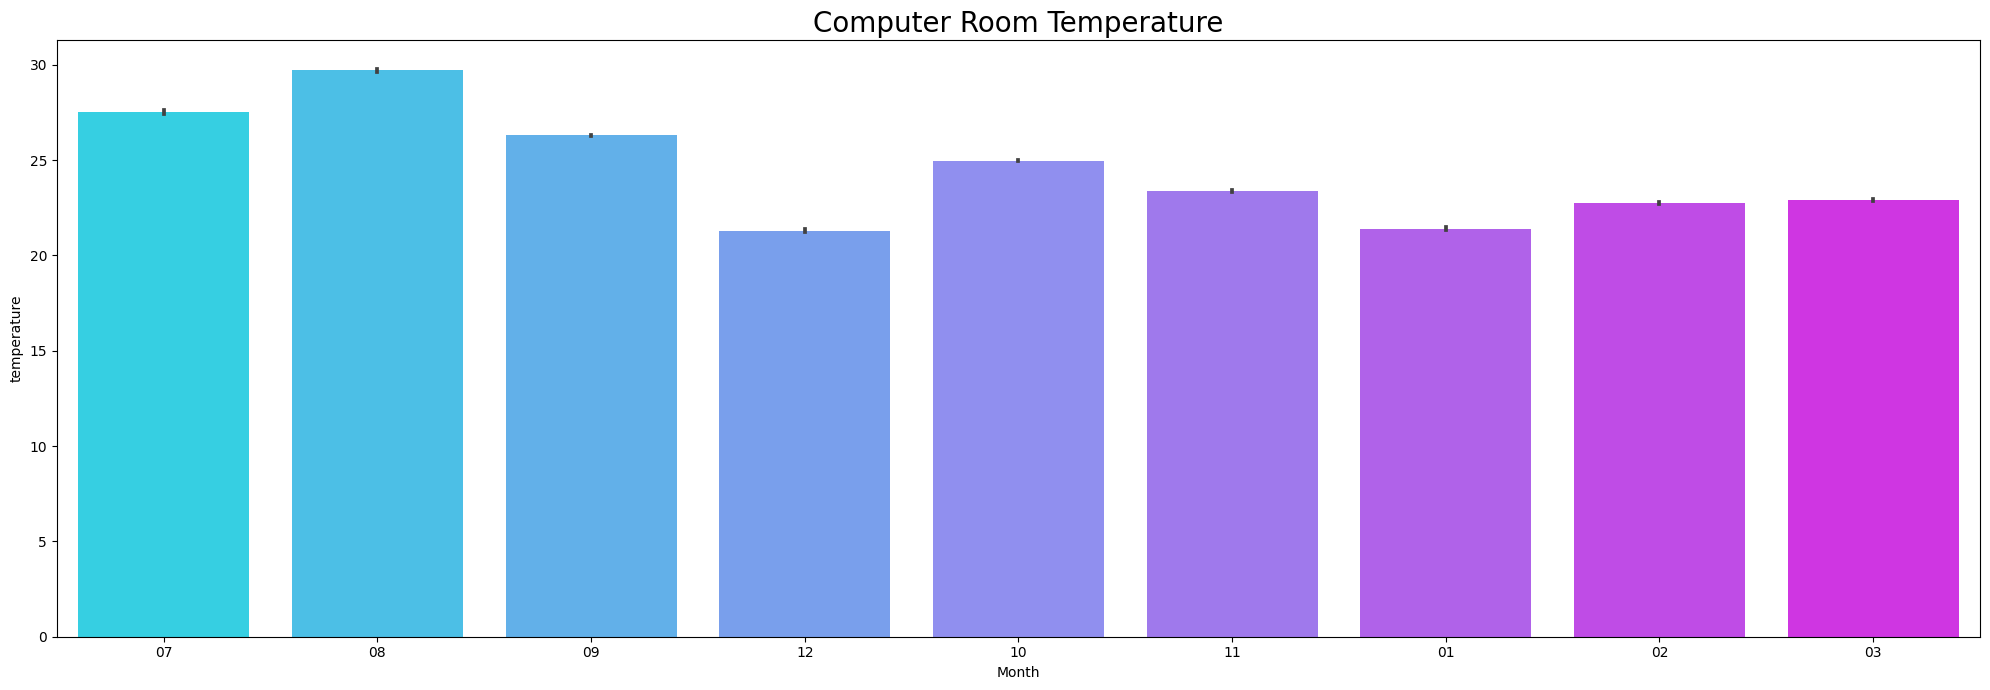

In [341]:
display_plot(Computer_Room_com, Computer_Room_com['Month'], Computer_Room_com['TM_outdoor'], "Computer Room TM Outdoor")
display_plot(Computer_Room_com, Computer_Room_com['Month'], Computer_Room_com['temperature'], "Computer Room Temperature")

In [343]:
# Test for normality, multimodality (Hartigan's Dip Test), and far outliers (Tukey's test)
table = TableOne(Computer_Room_com.drop(['Day', 'Month', 'Year','Hour', "Minutes", "o3"], axis = 1), dip_test=True, normal_test=True, tukey_test=True)
table

Missing        Overall
n                                             31489
co2, mean (SD)                     0   451.2 (90.4)
humidity, n (%)        22.0        0        1 (0.0)
                       22.5                 8 (0.0)
                       23.0                22 (0.1)
                       23.5                39 (0.1)
                       24.0                39 (0.1)
                       24.5                44 (0.1)
                       25.0                93 (0.3)
                       25.5               159 (0.5)
                       26.0               209 (0.7)
                       26.5               304 (1.0)
                       27.0               310 (1.0)
                       27.5               350 (1.1)
                       28.0               298 (0.9)
                       28.5               324 (1.0)
                       29.0               400 (1.3)
                       29.5               532 (1.7)
                       30.0               494 (1.6)
                       30.5               567 (1.8)
                       31.0               619 (2.0)
                       31.5               610 (1.9)
                       32.0               592 (1.9)
                       32.5               765 (2.4)
                       33.0               826 (2.6)
                       33.5               890 (2.8)
                       34.0               972 (3.1)
                       34.5               792 (2.5)
                       35.0               664 (2.1)
                       35.5               528 (1.7)
                       36.0               570 (1.8)
                       36.5               551 (1.7)
                       36.75                1 (0.0)
                       37.0               493 (1.6)
                       37.25                1 (0.0)
                       37.5               682 (2.2)
                       38.0               819 (2.6)
                       38.25                1 (0.0)
                       38.5               680 (2.2)
                       39.0               627 (2.0)
                       39.5               700 (2.2)
                       40.0               587 (1.9)
                       40.5               551 (1.7)
                       41.0               631 (2.0)
                       41.5               752 (2.4)
                       41.75                1 (0.0)
                       42.0               797 (2.5)
                       42.5               736 (2.3)
                       43.0               685 (2.2)
                       43.5               613 (1.9)
                       44.0               434 (1.4)
                       44.5               378 (1.2)
                       45.0               394 (1.3)
                       45.5               495 (1.6)
                       46.0               457 (1.5)
                       46.5               528 (1.7)
                       47.0               497 (1.6)
                       47.5               333 (1.1)
                       48.0               354 (1.1)
                       48.5               325 (1.0)
                       49.0               284 (0.9)
                       49.5               314 (1.0)
                       50.0               322 (1.0)
                       50.5               344 (1.1)
                       51.0               414 (1.3)
                       51.5               346 (1.1)
                       52.0               302 (1.0)
                       52.5               278 (0.9)
                       53.0               223 (0.7)
                       53.5               164 (0.5)
                       54.0               174 (0.6)
                       54.5               106 (0.3)
                       55.0               150 (0.5)
                       55.5               158 (0.5)
                       56.0               219 (0.7)
                       56.5               242 (0.8)
                       57

Tukey test indicates far outliers

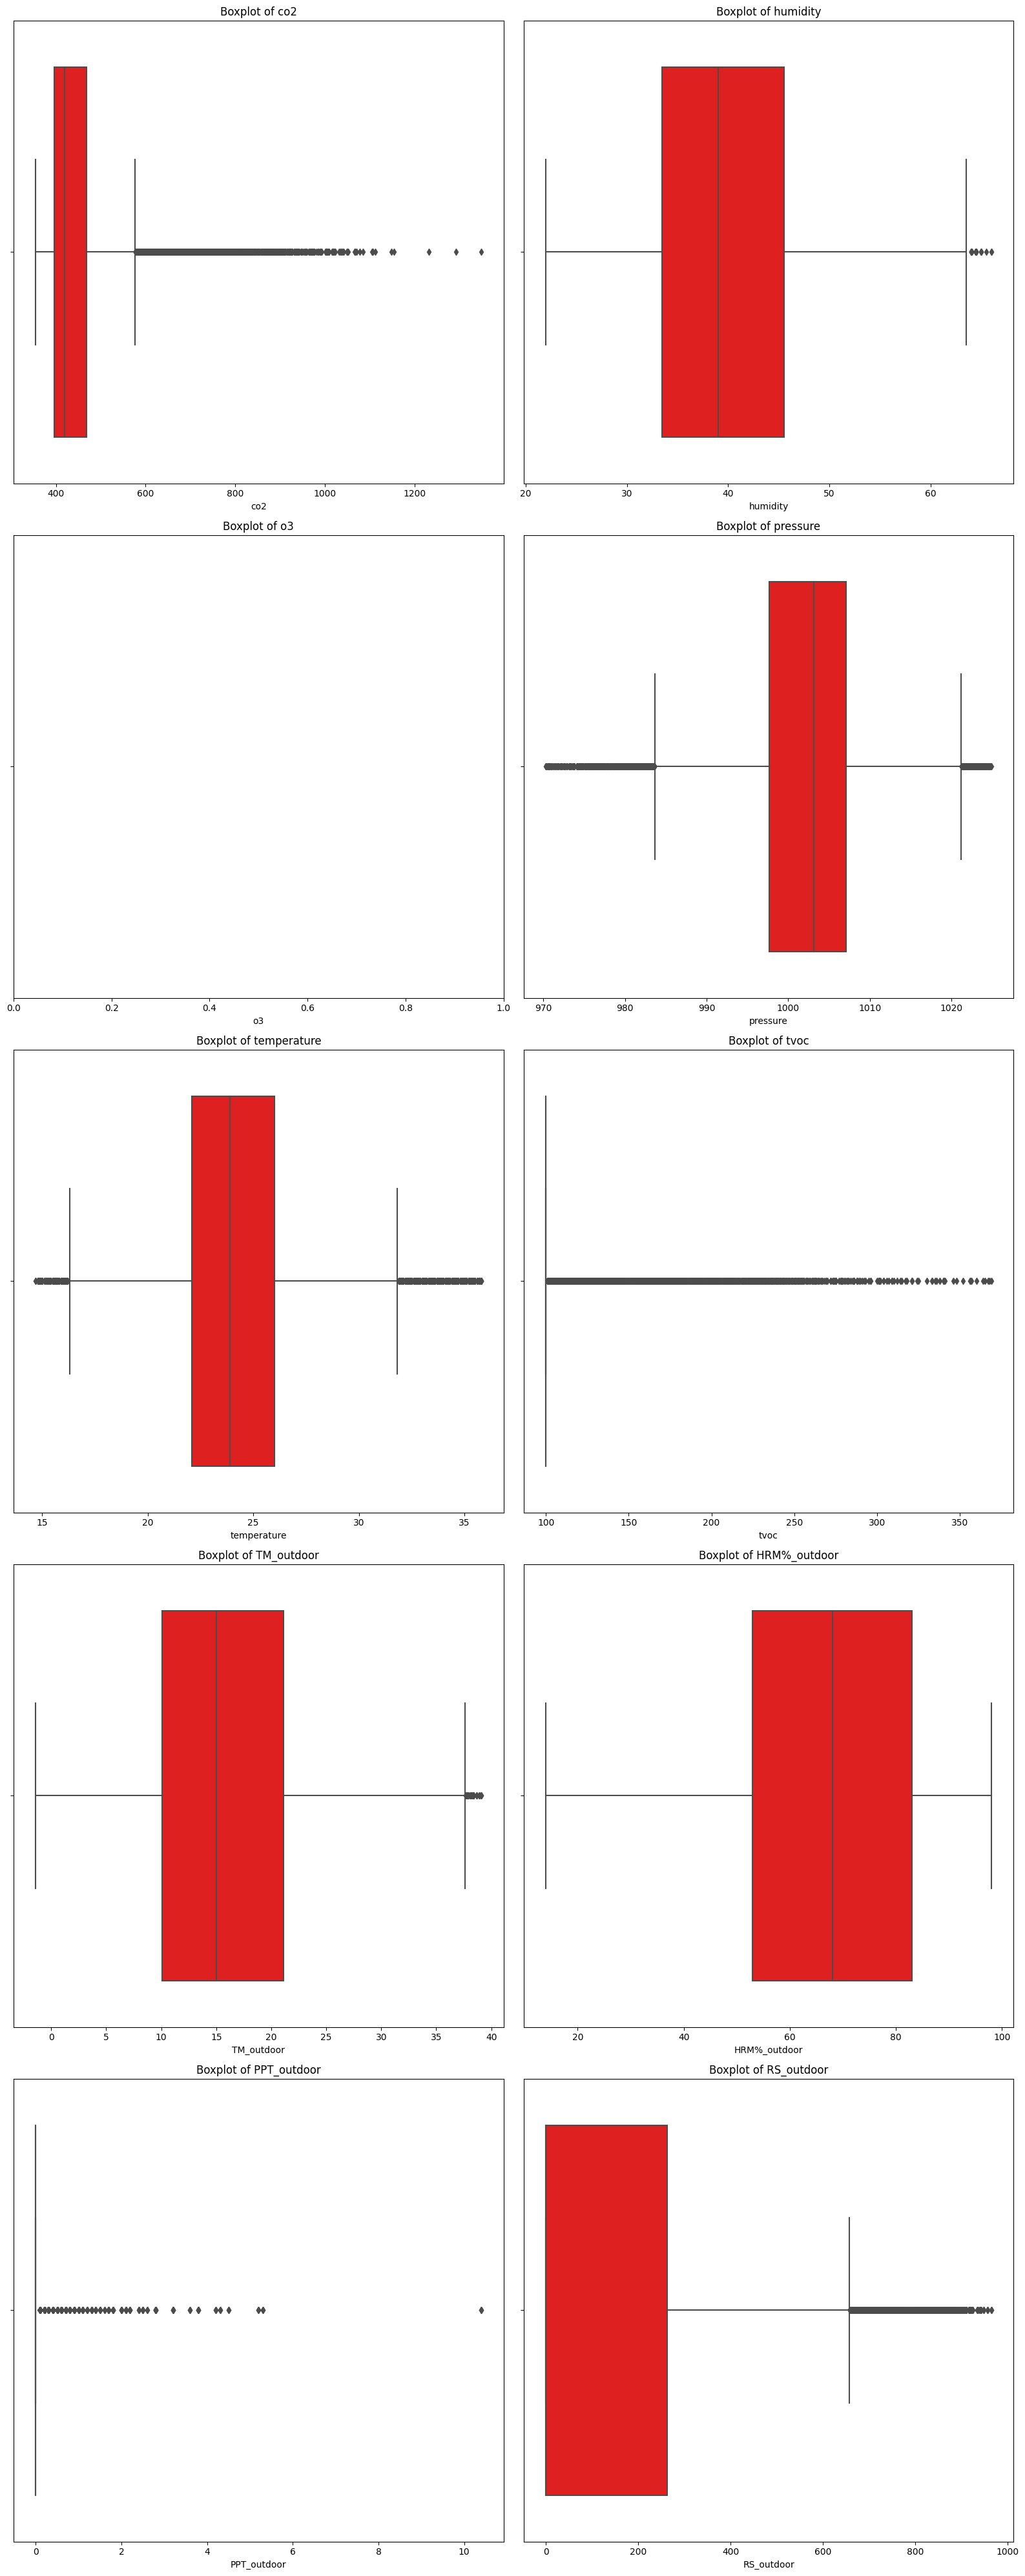

"Q1 = Computer_Room_com['co2'].quantile(0.25)\nQ3 = Computer_Room_com['co2'].quantile(0.75)\nIQR = Q3 - Q1\nlower_bound = Q1 - 1.5 * IQR\nupper_bound = Q3 + 1.5 * IQR\n\noutliers_co2 = Computer_Room_com[(Computer_Room_com['co2'] < lower_bound) | (Computer_Room_com['co2'] > upper_bound)]\n\noutliers_co2"

In [344]:
display_outliers(Computer_Room_com)
"""Q1 = Computer_Room_com['co2'].quantile(0.25)
Q3 = Computer_Room_com['co2'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_co2 = Computer_Room_com[(Computer_Room_com['co2'] < lower_bound) | (Computer_Room_com['co2'] > upper_bound)]

outliers_co2"""


Correlations

C:\Users\migue\AppData\Local\Temp\ipykernel_2008\3494042682.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sb.heatmap(Computer_Room_com.drop(['o3'], axis=1).corr(), cmap='BuGn', annot=True)


<AxesSubplot:>

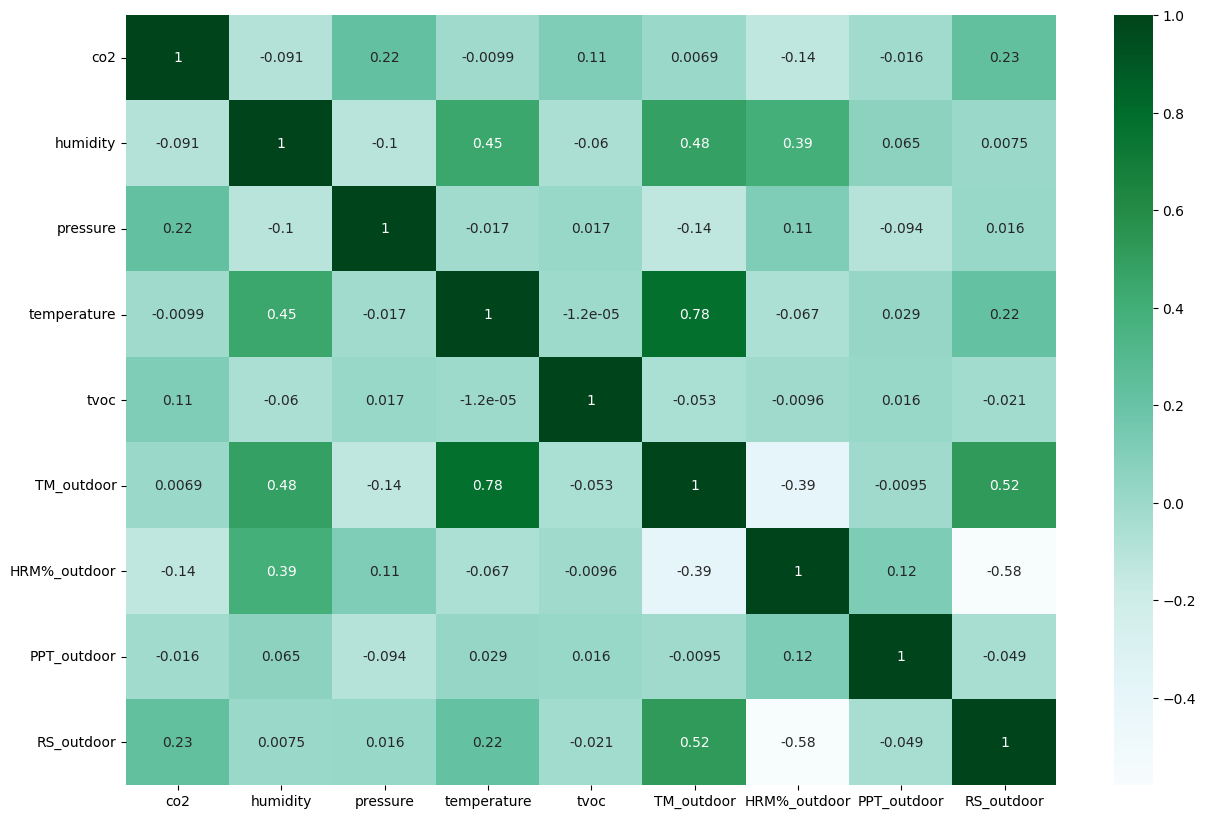

In [345]:
plt.figure(figsize=(15, 10))
sb.heatmap(Computer_Room_com.drop(['o3'], axis=1).corr(), cmap='BuGn', annot=True)

It can be seen that the columns co2, pressure, tvoc do not have a correlation with any of the other variables. This is because they are totally independent and are not affected by the others.

Since, for example, the CO2 and TVOC columns are variables related to the air quality of the room itself.

In [347]:
df_train=Computer_Room_com[['Day', 'Month', 'Year',"Hour","Minutes",'humidity','TM_outdoor', 'HRM%_outdoor', 'RS_outdoor', "temperature"]]

In [348]:
from sklearn.preprocessing import StandardScaler
scaler= StandardScaler()
scaler.fit(df_train)
df_train_scaled =scaler.transform(df_train)
print(df_train_scaled[0:6], '\n, \n')
df_train_scaled.shape

[[ 0.94678424 -0.05106564 -0.70820178  0.21717106  1.46567339 -0.35870115
   2.00246376 -2.33259561  2.83928783  0.92124869]
 [ 0.94678424 -0.05106564 -0.70820178  0.36200237 -1.4644637  -0.35870115
   2.00246376 -2.33259561  2.83928783  0.95048849]
 [ 0.94678424 -0.05106564 -0.70820178  0.36200237 -0.87843628 -0.35870115
   2.00246376 -2.33259561  2.83928783  0.95048849]
 [ 0.94678424 -0.05106564 -0.70820178  0.36200237 -0.29240887 -0.35870115
   2.0288565  -2.33259561  2.57131471  0.95048849]
 [ 0.94678424 -0.05106564 -0.70820178  0.36200237  0.29361855 -0.4174019
   2.0288565  -2.33259561  2.57131471  0.97972829]
 [ 0.94678424 -0.05106564 -0.70820178  0.36200237  0.87964597 -0.4174019
   2.0288565  -2.33259561  2.57131471  0.97972829]] 
, 



(31489, 10)

In [349]:
lags=8
forecasts=3
X, y = [], []
for i in range(len(df_train_scaled) - forecasts-lags):
  X.append(df_train_scaled[i:(i + lags)])
  y.append(df_train_scaled[:,-1][i+lags: i+lags+ forecasts])
X,y =  np.array(X), np.array(y)
df_train_scaled.shape, X.shape, y.shape

((31489, 10), (31478, 8, 10), (31478, 3))

In [350]:
size = int(len(X) * 0.80)
X_train = X[0:size]
y_train = y[0:size]
X_val = X[size:len(X)]
y_val = y[size:len(X)]
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((25182, 8, 10), (25182, 3), (6296, 8, 10), (6296, 3))

In [351]:
X_train, y_train, X_val, y_val[0:5]

(array([[[ 0.94678424, -0.05106564, -0.70820178, ..., -2.33259561,
           2.83928783,  0.92124869],
         [ 0.94678424, -0.05106564, -0.70820178, ..., -2.33259561,
           2.83928783,  0.95048849],
         [ 0.94678424, -0.05106564, -0.70820178, ..., -2.33259561,
           2.83928783,  0.95048849],
         ...,
         [ 0.94678424, -0.05106564, -0.70820178, ..., -2.33259561,
           2.57131471,  0.97972829],
         [ 0.94678424, -0.05106564, -0.70820178, ..., -2.33259561,
           2.23850939,  0.97972829],
         [ 0.94678424, -0.05106564, -0.70820178, ..., -2.33259561,
           2.23850939,  1.00896809]],
 
        [[ 0.94678424, -0.05106564, -0.70820178, ..., -2.33259561,
           2.83928783,  0.95048849],
         [ 0.94678424, -0.05106564, -0.70820178, ..., -2.33259561,
           2.83928783,  0.95048849],
         [ 0.94678424, -0.05106564, -0.70820178, ..., -2.33259561,
           2.57131471,  0.95048849],
         ...,
         [ 0.94678424, -0.0510656

In [352]:
n_steps = X_train.shape[-2]
n_features =X_train.shape[-1]
input_shape=(n_steps, n_features)
model_bi = Sequential([Bidirectional(LSTM(256, return_sequences=True), input_shape= input_shape),
    Dense(20, activation='tanh'),
    Bidirectional(LSTM(128,return_sequences=True, activation = 'tanh')),
    Dense(20, activation='tanh'),
    Bidirectional(LSTM(128,return_sequences=False, activation = 'tanh')),
    Dense(20, activation='tanh'),
    tf.keras.layers.Dropout(0.20),
    Dense(units=3, activation = 'linear'),
])
model_bi.compile(optimizer='adam', loss='mse')
model_bi.summary()
tf.keras.utils.plot_model(model_bi)

c:\Users\migue\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_33                │ (None, 8, 512)         │       546,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 8, 20)          │        10,260 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_34                │ (None, 8, 256)         │       152,576 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 8, 20)          │         5,140 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_35                │ (None, 256)            │       152,576 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 20)             │         5,140 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 3)              │            63 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 872,571 (3.33 MB)

 Trainable params: 872,571 (3.33 MB)

 Non-trainable params: 0 (0.00 B)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [353]:
from tensorflow.keras.optimizers import Adam

n_steps = X_train.shape[-2]
n_features =X_train.shape[-1]
#input_shape=(n_steps, n_features)
model=Sequential()
model.add(LSTM(128,activation='tanh',return_sequences=True, input_shape=(n_steps, n_features)))
model.add(Dropout(0.2))
model.add(LSTM(64,activation='tanh',return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64,activation='tanh'))
model.add(Dense(3, activation='linear'))
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')
model.summary()
tf.keras.utils.plot_model(model)

n_steps = X_train.shape[-2]
n_features =X_train.shape[-1]
#input_shape=(n_steps, n_features)
model=Sequential()
model.add(LSTM(128,activation='tanh',return_sequences=True, input_shape=(n_steps, n_features)))
model.add(Dropout(0.2))
model.add(LSTM(64,activation='tanh',return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64,activation='tanh'))
model.add(Dense(3, activation='linear'))
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')
model.summary()
tf.keras.utils.plot_model(model)

c:\Users\migue\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_90 (LSTM)                  │ (None, 8, 128)         │        71,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 8, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_91 (LSTM)                  │ (None, 8, 64)          │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_92 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 153,795 (600.76 KB)

 Trainable params: 153,795 (600.76 KB)

 Non-trainable params: 0 (0.00 B)

You must install pydot (`pip install pydot`) for `plot_model` to work.


Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_93 (LSTM)                  │ (None, 8, 128)         │        71,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_52 (Dropout)            │ (None, 8, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_94 (LSTM)                  │ (None, 8, 64)          │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_53 (Dropout)            │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_95 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 153,795 (600.76 KB)

 Trainable params: 153,795 (600.76 KB)

 Non-trainable params: 0 (0.00 B)

You must install pydot (`pip install pydot`) for `plot_model` to work.


Epoch 1/20
780/780 ━━━━━━━━━━━━━━━━━━━━ 37s 32ms/step - loss: 0.1405 - val_loss: 0.0088
Epoch 2/20
780/780 ━━━━━━━━━━━━━━━━━━━━ 23s 30ms/step - loss: 0.0370 - val_loss: 0.0023
Epoch 3/20
780/780 ━━━━━━━━━━━━━━━━━━━━ 24s 31ms/step - loss: 0.0302 - val_loss: 0.0038
Epoch 4/20
780/780 ━━━━━━━━━━━━━━━━━━━━ 24s 31ms/step - loss: 0.0258 - val_loss: 0.0053
Epoch 5/20
780/780 ━━━━━━━━━━━━━━━━━━━━ 24s 31ms/step - loss: 0.0248 - val_loss: 0.0028
Epoch 5: early stopping


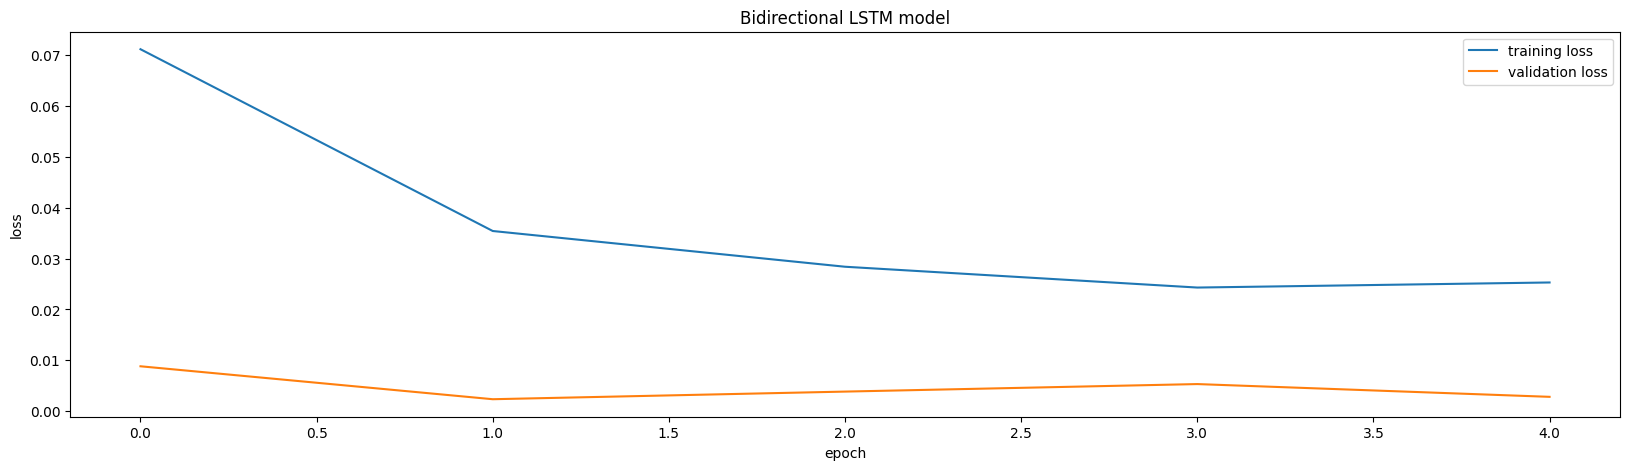

197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step

 
 Model Evaluation Report: 
Mean Absolute Error(MAE) of Bidirectional LSTM model : 0.04036411344712656
Mean Squared Error(MSE) of Bidirectional LSTM model : 0.0036478535153751657
Root Mean Squared Error (RMSE) of Bidirectional LSTM model : 0.06015098053703669
Mean absolute percentage error (MAPE) of Bidirectional LSTM model : 0.24299853697384455
Explained Variance Score (EVS) of Bidirectional LSTM model : 0.9802168653602132
R2 of Bidirectional LSTM model : 0.98

 



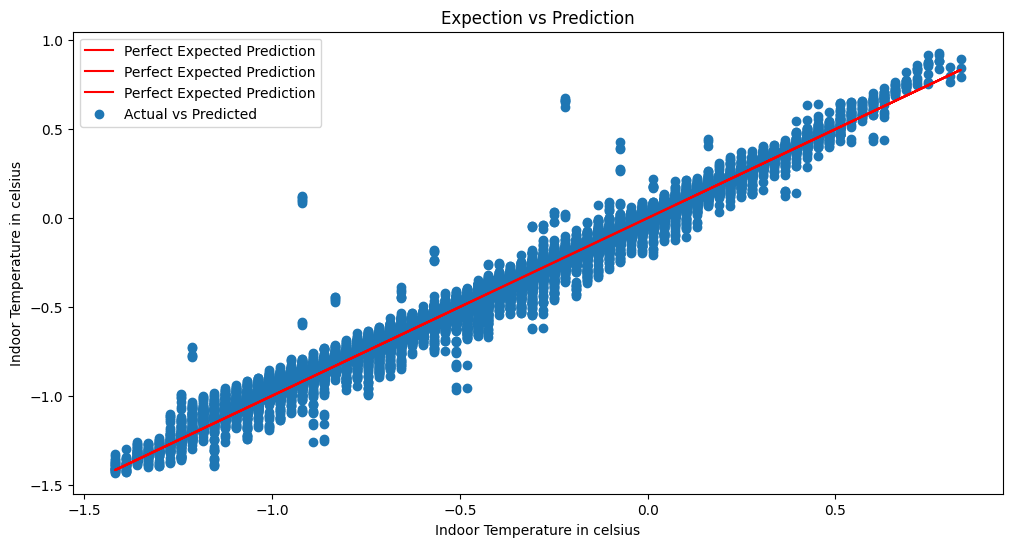

In [354]:
def model_train_evaluation(y, X, model, model_name):
    #Model run
    from tensorflow.keras.callbacks import EarlyStopping
    early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
    #history = model.fit(X_train,y_train, epochs=6,validation_data=(X_val, y_val),callbacks=early_stop)
    history = model.fit(X_train,y_train, epochs=20,validation_split=0.01, callbacks=early_stop)
    history_frame = pd.DataFrame(history.history)
    
    # model performance plot
    plt.figure(figsize=(20,5))
    plt.plot(history.history['loss'], label='training loss')
    plt.plot(history.history['val_loss'], label='validation loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(loc='best')
    plt.title(model_name)
    plt.show()
    
    # Model Evaluation metrics
    from sklearn.metrics import mean_squared_error,mean_absolute_error,explained_variance_score, r2_score, mean_absolute_percentage_error
    ypred =model.predict(X)
    print("\n \n Model Evaluation Report: ")
    print('Mean Absolute Error(MAE) of', model_name,':', mean_absolute_error(y, ypred))
    print('Mean Squared Error(MSE) of', model_name,':', mean_squared_error(y, ypred))
    print('Root Mean Squared Error (RMSE) of', model_name,':', mean_squared_error(y, ypred, squared = False))
    print('Mean absolute percentage error (MAPE) of', model_name,':', mean_absolute_percentage_error(y, ypred))
    print('Explained Variance Score (EVS) of', model_name,':', explained_variance_score(y, ypred))
    print('R2 of', model_name,':', (r2_score(y, ypred)).round(2))
    print('\n \n')
    
    # Actual vs Predicted Plot
    f, ax = plt.subplots(figsize=(12,6),dpi=100);
    plt.scatter(y, ypred, label="Actual vs Predicted")
    # Perfect predictions
    plt.xlabel('Indoor Temperature in celsius')
    plt.ylabel('Indoor Temperature in celsius')
    plt.title('Expection vs Prediction')
    plt.plot(y,y,'r', label="Perfect Expected Prediction")
    plt.legend()



# Call the model_train_evaluation function
model_train_evaluation(y_val, X_val, model_bi, 'Bidirectional LSTM model')


Epoch 1/20
780/780 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - loss: 0.1537 - val_loss: 0.0061
Epoch 2/20
780/780 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 0.0152 - val_loss: 0.0060
Epoch 3/20
780/780 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 0.0131 - val_loss: 0.0036
Epoch 4/20
780/780 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 0.0101 - val_loss: 0.0051
Epoch 5/20
780/780 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 0.0095 - val_loss: 0.0026
Epoch 6/20
780/780 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 0.0081 - val_loss: 0.0031
Epoch 7/20
780/780 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 0.0084 - val_loss: 0.0031
Epoch 8/20
780/780 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 0.0072 - val_loss: 0.0024
Epoch 9/20
780/780 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 0.0072 - val_loss: 0.0021
Epoch 10/20
780/780 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 0.0064 - val_loss: 0.0020
Epoch 11/20
780/780 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 0.0065 - val_loss: 0.0047
Epoch 12/20
780/780 ━━━━━━━━━━━━━

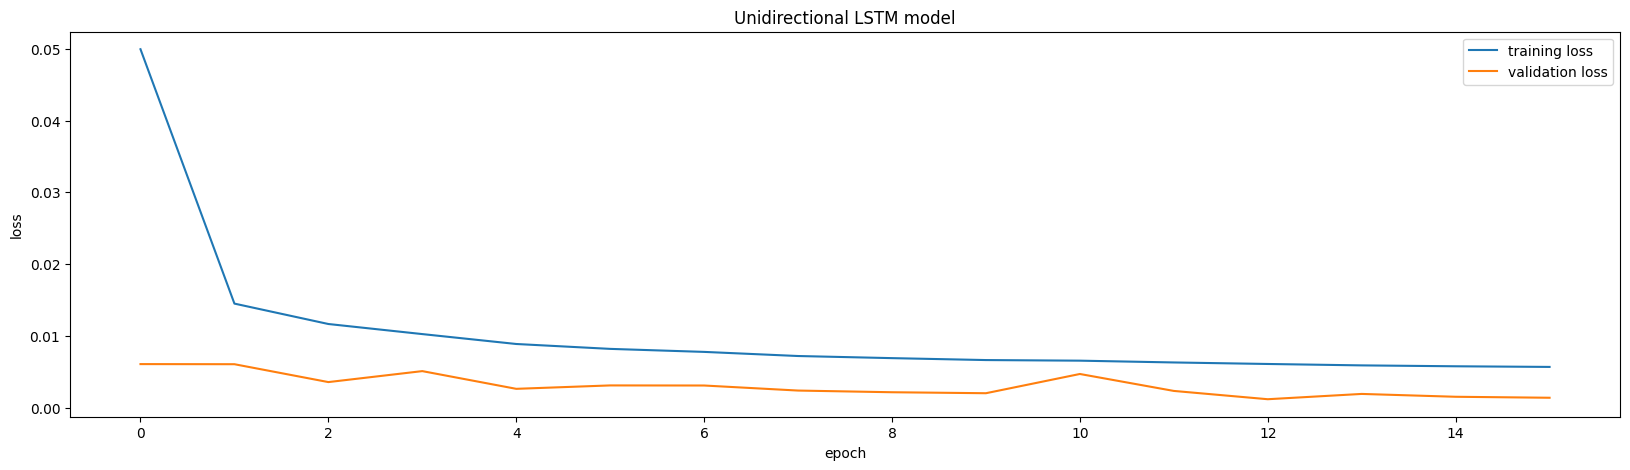

197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step

 
 Model Evaluation Report: 
Mean Absolute Error(MAE) of Unidirectional LSTM model : 0.03741253898387245
Mean Squared Error(MSE) of Unidirectional LSTM model : 0.0031177251218973564
Root Mean Squared Error (RMSE) of Unidirectional LSTM model : 0.05553457070795325
Mean absolute percentage error (MAPE) of Unidirectional LSTM model : 0.26325318263535474
Explained Variance Score (EVS) of Unidirectional LSTM model : 0.9837724606328074
R2 of Unidirectional LSTM model : 0.98

 



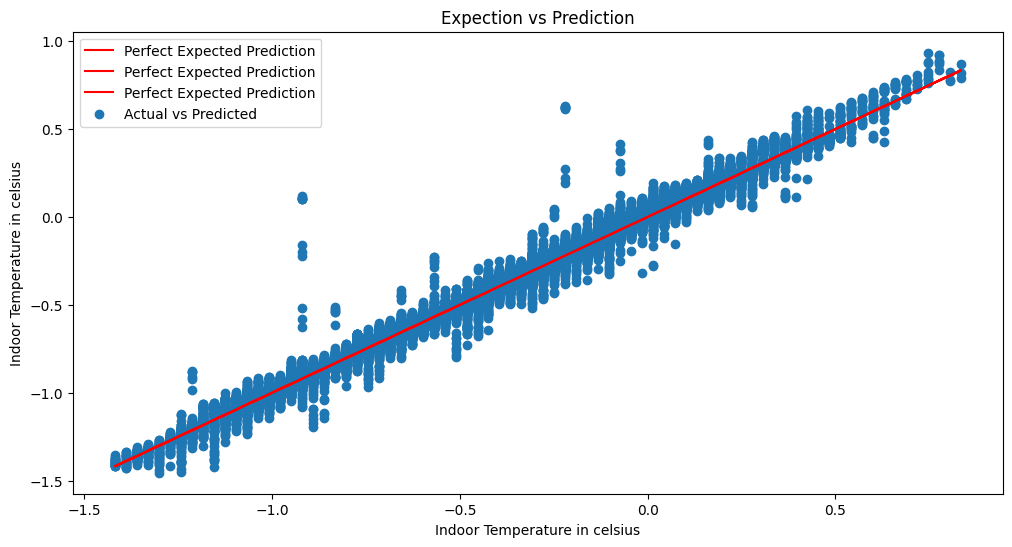

In [355]:
model_train_evaluation(y_val, X_val,model, 'Unidirectional LSTM model')

In [356]:
import pandas as pd

data_test = {
    'Day': ["06", "06", "06", "06"],
    'Month': ["05","05","05", "05"] ,
    'Year': ["2024", "2024", "2024", "2024"],
    'Hour': ['18', '18', '18', '18'],
    'Minutes': ['00', '10', '20', '30'],
    'co2': [405.0, 399.0, 403.0, 398.0],
    'humidity': [38.0, 37.5, 37.0, 36.5],
    'o3': [None, None, None, None],  
    'pressure': [985.0, 985.1, 985.1, 985.2],
    'tvoc': [100.0, 100.0, 100.0, 100.0],
    'TM_outdoor': [17.0, 15.0, 15.0, 13.0],
    'HRM%_outdoor': [44, 47, 47, 47],
    'PPT_outdoor': [0.0, 0.0, 0.0, 0.0],
    'RS_outdoor': [340, 340, 340, 340]
}

df_new = pd.DataFrame(data_test)




In [357]:
df_test=df_new[['Day', 'Month', 'Year','Hour', 'Minutes', 'humidity', 'TM_outdoor', 'HRM%_outdoor', 'RS_outdoor']]
df_test

,Day,Month,Year,Hour,Minutes,humidity,TM_outdoor,HRM%_outdoor,RS_outdoor
0,06,05,2024,18,00,38.0,17.0,44,340
1,06,05,2024,18,10,37.5,15.0,47,340
2,06,05,2024,18,20,37.0,15.0,47,340
3,06,05,2024,18,30,36.5,13.0,47,340


In [358]:
train_test=df_train.append(df_test,ignore_index=True).fillna(0)
train_test

C:\Users\migue\AppData\Local\Temp\ipykernel_2008\237083430.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_test=df_train.append(df_test,ignore_index=True).fillna(0)


,Day,Month,Year,Hour,Minutes,humidity,TM_outdoor,HRM%_outdoor,RS_outdoor,temperature
0,25,07,2023,13,50,37.0,31.0,25,808,27.4
1,25,07,2023,14,00,37.0,31.0,25,808,27.5
2,25,07,2023,14,10,37.0,31.0,25,808,27.5
3,25,07,2023,14,20,37.0,31.2,25,746,27.5
4,25,07,2023,14,30,36.5,31.2,25,746,27.6
...,...,...,...,...,...,...,...,...,...,...
31488,30,03,2024,12,20,36.0,15.1,51,525,22.9
31489,06,05,2024,18,00,38.0,17.0,44,340,0.0
31490,06,05,2024,18,10,37.5,15.0,47,340,0.0
31491,06,05,2024,18,20,37.0,15.0,47,340,0.0


In [359]:
y_mean=df_train['temperature'].mean()
y_std=scaler.scale_[df_train.shape[1]-1]
y_mean, y_std

(24.249333100447775, 3.419996083263395)

In [360]:
for i in range(len(df_train),len(train_test)):
    X_test=train_test[i-lags:i]
    X_test=scaler.transform(X_test)
    val=model_bi.predict(X_test.reshape(1,lags,X_test.shape[1]))
    val2=y_std*val[:,0]+y_mean
    train_test.loc[i,'temperature']=val2
    
final_test = train_test[len(df_train):][['temperature']]
final_test

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


,temperature
31489,22.870821
31490,23.198578
31491,23.446484
31492,23.677393
